In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys

# TODO: change this to the path to your homework folder
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '445 project/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
os.chdir(GOOGLE_DRIVE_PATH)

['aita_clean.csv', 'glove300.kv', 'glove300.kv.vectors.npy', '__pycache__', 'aita_minimal_preprocess.csv', 'model.py', 'train.pt', 'dev.pt', 'model.ipynb']


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
import nltk
from model import *
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

# nltk.download('punkt')

In [2]:
aita_raw_df = pd.read_csv('aita_minimal_preprocess.csv')
aita_raw_df

,Unnamed: 0,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole,post,length
0,0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0,1,[AITA] I wrote an explanation in TIL and came ...,106
1,1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1393290576.0,asshole,140,27.0,1,[AITA] Threw my parent's donuts awayMy parents...,180
2,2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0,0,I told a goth girl she looked like a clown.I w...,13
3,3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,1393286962.0,everyone sucks,22,3.0,1,[AItA]: Argument I had with another redditor i...,21
4,4,1yueqb,1.393288e+09,[AITA] I let my story get a little long and bo...,NaN,False,not the asshole,6,4.0,0,[AITA] I let my story get a little long and bo...,25
...,...,...,...,...,...,...,...,...,...,...,...,...
97623,97623,ex94w5,1.580577e+09,AITA for telling my sister she is being a spoi...,My sister(17F) and I(15M) are white kids born ...,1580585457.0,not the asshole,16,23.0,0,AITA for telling my sister she is being a spoi...,170
97624,97624,ex970f,1.580577e+09,AITA for telling my husband to f* off after he...,My husband (28M) and I (32F) are married for a...,1580584475.0,not the asshole,1373,304.0,0,AITA for telling my husband to f* off after he...,545
97625,97625,ex9dwo,1.580578e+09,AITA for attempting to keep my students out of...,Upfront apologies for formatting. I’m also try...,False,not the asshole,4,15.0,0,AITA for attempting to keep my students out of...,419
97626,97626,ex9egs,1.580578e+09,WIBTA if I left my brothers fate up to the state?,A little back story my mom is a drug addict an...,False,not the asshole,280,140.0,0,WIBTA if I left my brothers fate up to the sta...,283


In [ ]:
aita_gt500 = aita_raw_df.loc[aita_raw_df["length"] > 500][aita_raw_df["length"] < 1000]
aita_gt500

<ipython-input-26-32420687d0c3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  aita_gt500 = aita_raw_df.loc[aita_raw_df["length"] > 500][aita_raw_df["length"] < 1000]


,Unnamed: 0,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole,post,length
7,7,1yvb3n,1.393307e+09,[AITA] My roommate has many undesirable qualit...,I'm a college student. My first roommate dropp...,False,asshole,3,4.0,1,[AITA] My roommate has many undesirable qualit...,692
13,13,1yxnp3,1.393369e+09,Argument with a friend via text message (may b...,I'm likely going to get some flak for arguing ...,False,everyone sucks,9,31.0,1,Argument with a friend via text message (may b...,806
20,20,1z313z,1.393508e+09,Standing up at a John Mayer concert,Hi /r/AmITheAsshole! I just heard this communi...,False,not the asshole,18,17.0,0,Standing up at a John Mayer concertHi /r/AmITh...,577
29,29,20siao,1.395210e+09,AITA for not being appreciative enough of the ...,Recently I spent a good amount of time traveli...,False,not the asshole,4,11.0,0,AITA for not being appreciative enough of the ...,741
31,31,20ydkp,1.395363e+09,[AITA] Just barely avoided a fender-bender in ...,"So, I live in a college neighborhood. I was ju...",False,not the asshole,17,18.0,0,[AITA] Just barely avoided a fender-bender in ...,634
...,...,...,...,...,...,...,...,...,...,...,...,...
97610,97610,ex8bjp,1.580574e+09,AITA for making my step mom buy me new Tupperw...,"So, my dads house caught on fire about a month...",1580614636.0,not the asshole,143,123.0,0,AITA for making my step mom buy me new Tupperw...,918
97614,97614,ex8hnd,1.580574e+09,AITA for not wanting to reconcile with one of ...,I have maintained the same friend group since ...,False,not the asshole,10,12.0,0,AITA for not wanting to reconcile with one of ...,665
97619,97619,ex8su3,1.580576e+09,AITA for knocking on my neighbours' wall?,Hi. I (24M) had new neighbours a bit more tha...,False,not the asshole,4,17.0,0,AITA for knocking on my neighbours' wall? Hi. ...,677
97622,97622,ex8ywl,1.580576e+09,AITA for giving my brother my Air Force Ribbon?,"Yo.\n\nSo, I am pretty well off (upper middle ...",False,not the asshole,3,44.0,0,AITA for giving my brother my Air Force Ribbon...,584


In [14]:
aita_raw_df['is_asshole'].value_counts()

0    71117
1    26511
Name: is_asshole, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    aita_raw_df.post.values, 
    aita_raw_df.is_asshole.values,
    stratify = aita_raw_df.is_asshole.values,
    test_size = 0.2, 
    random_state = 448
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    stratify = y_train,
    test_size = 0.2, 
    random_state = 448
)
print(X_train[0])
print(y_train[0])

AITA for wanting to dump a girl after finding out she has an STD?So I (32m) started dating a new girl (26f) after a disgusting horrible divorce from my wife who I’ve been with for like 15 years.. 

So I was super patent and deliberate in choosing a girl to date, turning down lots of others over the last year or so of separation... Then I met this girl and she is like EVERYTHING I want in a woman, and I could really see myself having a long-term relationship with her. 

We took things slow and waited about a month to have sex, just fooling around and doing other stuff. Then when the time came she stopped me right before and told me she had been living with herpes since the age of 19.. She was very mature and responsible and understanding and said she’d give me time to think about it, but...TBH I’m fucking freaking out. I’m terrified that this could affect me and my life forever if I end up being with her.

I basically told her all of this, and broke up with her. I said that I couldn’t r

In [3]:
embed = KeyedVectors.load('glove300.kv')

In [4]:
unk = torch.FloatTensor(np.mean(embed.vectors, axis=0))

In [5]:
embed_tensor_dict = tensor_embeds(embed)

/home/maroofr/class/448/mde/nn/model.py:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return {k: torch.FloatTensor(embed[k]) for k in embed.index_to_key}


In [16]:
train_data = AITADataset(X_train, y_train, embed_tensor_dict, unk)
dev_data = AITADataset(X_val, y_val, embed_tensor_dict, unk)
test_data = AITADataset(X_test, y_test, embed_tensor_dict, unk)

In [18]:
train_loader = DataLoader(train_data, batch_size=16, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=16, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, collate_fn=basic_collate_fn, shuffle=False)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
overfit_df = aita_raw_df[aita_raw_df["length"] > 500][:1000]
overfit_data = AITADataset(overfit_df.post.values, overfit_df.is_asshole.values, embed_tensor_dict, unk)
overfit_loader = DataLoader(overfit_data, batch_size=32, collate_fn=basic_collate_fn, shuffle=True)

------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 32-- batch loss = 0.5640
Validation accuracy: 0.5128
Validation loss: 0.5673
Epoch No. 2--Iteration No. 64-- batch loss = 0.7498
Validation accuracy: 0.5019
Validation loss: 0.5154
Epoch No. 3--Iteration No. 96-- batch loss = 0.5821
Validation accuracy: 0.5745
Validation loss: 0.5202
Epoch No. 4--Iteration No. 128-- batch loss = 0.7994
Validation accuracy: 0.9674
Validation loss: 0.1195
Epoch No. 5--Iteration No. 160-- batch loss = 0.2019
Validation accuracy: 0.9844
Validation loss: 0.0262
Epoch No. 6--Iteration No. 192-- batch loss = 0.1052
Validation accuracy: 0.9939
Validation loss: 0.0407
Epoch No. 7--Iteration No. 224-- batch loss = 0.0068
Validation accuracy: 0.9974
Validation loss: 0.0060
Training lasted 2.61 minutes
------------------------ Training Done ------------------------


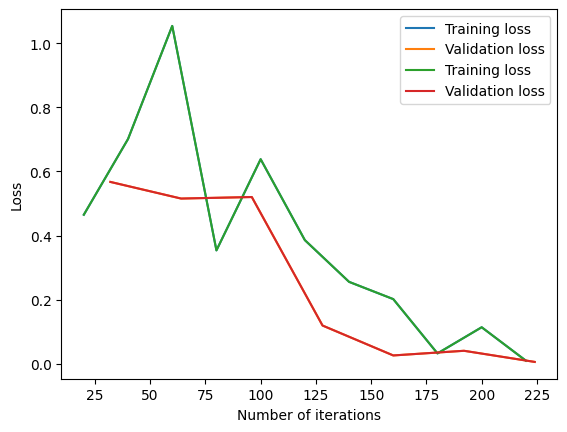

In [8]:
# test on validation to see if overfit is possible
torch.cuda.empty_cache() 
net = ensembleCNNBiGRU(256, 256, device, 0)
net.to(device)
optim = get_optimizer(net, lr=1e-2, weight_decay=0)
best_model, stats = train_model(net, overfit_loader, overfit_loader, optim,
                                num_epoch=7, collect_cycle=20, device=device, patience=None)
plot_loss(stats, False)
plot_loss(stats, True)

In [21]:
import itertools
from tqdm.notebook import tqdm

# Credit for this and a bunch of the training/validation code to EECS 487 staff
def search_param():
    """Experiemnt on different hyper parameters."""
    cnn_dense_hidden_dim, rnn_dense_hidden_dim, dropout_rate, lr, weight_decay = [256], [256], [0.5], [0.01], [0.001]
    total_comb = len(cnn_dense_hidden_dim) * len(rnn_dense_hidden_dim) * len(dropout_rate) * len(lr) * len(weight_decay)
    print("cnn hidden from: {}\nrnn hidden from: {}\nlr from: {}\nwd from: {}\ndropout from: {}".format(
        cnn_dense_hidden_dim, rnn_dense_hidden_dim, lr, weight_decay, dropout_rate
    ))
    best_model, best_stats = None, None
    best_accuracy, best_lr, best_wd, best_cnn_hd, best_rnn_hd, best_dr = 0, 0, 0, 0, 0, 0
    for cnn_hd, rnn_hd, dr, lr, wd in tqdm(
        itertools.product(cnn_dense_hidden_dim, rnn_dense_hidden_dim, dropout_rate, lr, weight_decay),
        total=total_comb
    ):
        net = ensembleCNNBiGRU(cnn_hd, rnn_hd, device, dr).to(device)
        optim = get_optimizer(net, lr=lr, weight_decay=wd)
        model, stats = train_model(net, train_loader, dev_loader, optim, num_epoch=100,
                                   collect_cycle=500, device=device, verbose=True, patience=10)
        # print accuracy
        print(f"{(cnn_hd, rnn_hd, dr, lr, wd)}: {stats['accuracy']}")
        # update best parameters if needed
        if stats['accuracy'] > best_accuracy:
            best_accuracy = stats['accuracy']
            best_model, best_stats = model, stats
            best_lr, best_wd, best_cnn_hd, best_rnn_hd, best_dr = lr, wd, cnn_hd, rnn_hd, dr
    print("\n\nBest cnn hidden: {}, Best rnn hidden: {}, Best weight_decay: {}, Best lr: {}, Best dropout: {}".format(
        best_cnn_hd, best_rnn_hd, best_wd, best_lr, best_dr))
    print("Accuracy: {:.4f}".format(best_accuracy))
    plot_loss(best_stats)
    return best_model
basic_model = search_param()

cnn hidden from: [256]
 rnn hidden from: [256]
lr from: [0.01]
wd from: [0.001]
dropout from: [0.5]


  0%|          | 0/1 [00:00<?, ?it/s]

------------------------ Start Training ------------------------


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
